In [1]:
import os, sys
sys.path.append('../src/')
from copulae1 import *

import requests
import urllib, json

import datetime
import pytz

def convert_datetime_timezone(dt, tz1, tz2):
    # dt: date time string
    # tz1: initial time zone
    # tz2: target time zone
    tz1 = pytz.timezone(tz1)
    tz2 = pytz.timezone(tz2)
    
    if type(dt) == pd.core.series.Series:
        dt = list(pd.to_datetime(dt, "%Y-%m-%d %H:%M:%S"))
        dt = [tz1.localize(d) for d in dt]
        dt = [d.astimezone(tz2) for d in dt]
        return pd.Series(dt)
        
    else:
        dt = datetime.datetime.strptime(dt,"%Y-%m-%d %H:%M:%S")
        dt = tz1.localize(dt)
        dt = dt.astimezone(tz2)
        return dt

## Get and clean CRIX

In [2]:
# Get CRIX as json file
url = "http://data.thecrix.de/data/crix.json"
response = urllib.request.urlopen(url)

CRIX_raw = json.loads(response.read())

CRIX_raw = pd.DataFrame(CRIX_raw)
CRIX_raw.columns = ['Date_UTC', 'CRIX_open'] # rename
CRIX_raw.Date_UTC = pd.to_datetime(CRIX_raw.Date_UTC) # change to datetime
CRIX_raw.Date_UTC = convert_datetime_timezone(CRIX_raw.Date_UTC, "UTC", "UTC") # Add timezone information
CRIX_raw.sort_index(ascending=False, inplace=True) # from new to old
CRIX_raw.reset_index(inplace=True, drop=True)
CRIX_raw.set_index('Date_UTC', inplace=True)
CRIX_raw.to_csv('../data/raw_data/CRIX_raw_20210324.csv') 
CRIX_raw.to_hdf('../data/raw_data/CRIX_raw_20210324.h5', key='CRIX_raw') 

In [3]:
# Sanity Check
CRIX_raw = pd.read_hdf('../data/raw_data/CRIX_raw_20210324.h5')
CRIX_raw.head()

,CRIX_open
Date_UTC,
2021-04-05 00:00:00+00:00,176984.294582
2021-04-04 00:00:00+00:00,168554.277122
2021-04-03 00:00:00+00:00,175212.972761
2021-04-02 00:00:00+00:00,169487.249742
2021-04-01 00:00:00+00:00,165773.267364


## Clean CME future
useful link of timezone difference: https://www.worldtimebuddy.com/cst-to-utc-converter

In [2]:
future_raw = pd.read_excel('../data/raw_data/btc_future.xlsx')

# change timezone from Berlin to UTC
future_raw.index = convert_datetime_timezone(future_raw.Date,
                                             "Europe/Berlin", "UTC")

In [5]:
future_Open = future_raw.Open
future_Close = future_raw.Close

# the closing price is retrieved 23 hours after market open
future_Close.index = future_Close.index + datetime.timedelta(hours=23)

In [6]:
future_Close

2021-02-04 22:00:00+00:00    38220.0
2021-02-03 22:00:00+00:00    37790.0
2021-02-02 22:00:00+00:00    36535.0
2021-02-01 22:00:00+00:00    34265.0
2021-01-29 22:00:00+00:00    35180.0
2021-01-28 22:00:00+00:00    33085.0
2021-01-27 22:00:00+00:00    31905.0
2021-01-26 22:00:00+00:00    32565.0
2021-01-25 22:00:00+00:00    34210.0
2021-01-22 22:00:00+00:00    34265.0
2021-01-21 22:00:00+00:00    32570.0
2021-01-20 22:00:00+00:00    35875.0
2021-01-19 22:00:00+00:00    37575.0
2021-01-15 22:00:00+00:00    36535.0
2021-01-14 22:00:00+00:00    40520.0
2021-01-13 22:00:00+00:00    37330.0
2021-01-12 22:00:00+00:00    35420.0
2021-01-11 22:00:00+00:00    34680.0
2021-01-08 22:00:00+00:00    40505.0
2021-01-07 22:00:00+00:00    40630.0
2021-01-06 22:00:00+00:00    37545.0
2021-01-05 22:00:00+00:00    35375.0
2021-01-04 22:00:00+00:00    32385.0
2020-12-31 22:00:00+00:00    30000.0
2020-12-30 22:00:00+00:00    29790.0
2020-12-29 22:00:00+00:00    27810.0
2020-12-28 22:00:00+00:00    27755.0
2

In [33]:
def closest_date(dt):
    # dt: Pandas Timestamp 
    _tz = dt.tz
    dt = datetime.datetime(dt.year, dt.month, dt.day, dt.hour,dt.minute).astimezone(_tz)
    if (dt.hour <= 12):
        if (dt.minute == 0):
            return pd.to_datetime(datetime.datetime(dt.year, dt.month, dt.day, 0,0))
        else:
            return pd.to_datetime(datetime.datetime(dt.year, dt.month, dt.day, 0,0)+ datetime.timedelta(days=1))
    else:
        return pd.to_datetime(datetime.datetime(dt.year, dt.month, dt.day, 0,0)+ datetime.timedelta(days=1))


In [34]:
# Strip hours and minutes
future_date = pd.Series([closest_date(future_Open.index[i]) for i in range(len(future_Open))])
future_date.index = future_date
future_date = future_date.tz_localize('UTC')
future_date = future_date.reset_index().iloc[:,0]

# Reindex the Opening price to the closest date (backward filling)
future_Open_reindexed = future_Open.reindex(future_date, method='nearest')

In [35]:
future_Open.head()

2021-02-03 23:00:00+00:00    38080.0
2021-02-02 23:00:00+00:00    36360.0
2021-02-01 23:00:00+00:00    34205.0
2021-01-31 23:00:00+00:00    33715.0
2021-01-28 23:00:00+00:00    33995.0
Name: Open, dtype: float64

In [36]:
future_Open_reindexed.head()

index
2021-02-04 00:00:00+00:00    38080.0
2021-02-03 00:00:00+00:00    36360.0
2021-02-02 00:00:00+00:00    34205.0
2021-02-01 00:00:00+00:00    33715.0
2021-01-29 00:00:00+00:00    33995.0
Name: Open, dtype: float64

In [37]:
future_Open_reindexed.head()

index
2021-02-04 00:00:00+00:00    38080.0
2021-02-03 00:00:00+00:00    36360.0
2021-02-02 00:00:00+00:00    34205.0
2021-02-01 00:00:00+00:00    33715.0
2021-01-29 00:00:00+00:00    33995.0
Name: Open, dtype: float64

In [38]:
# Prepare for merge
future_Open_reindexed = pd.DataFrame(future_Open_reindexed)

CRIX_raw = pd.read_hdf('../data/raw_data/CRIX_raw_20210324.h5')
CRIX_raw.reset_index(inplace=True)

In [39]:
CRIX_future_Open = CRIX_raw.merge(future_Open_reindexed, left_on='Date_UTC', right_on='index')

In [40]:
CRIX_future_Open

,Date_UTC,CRIX_open,Open
0,2021-02-04 00:00:00+00:00,104518.468839,38080.0
1,2021-02-03 00:00:00+00:00,98949.179255,36360.0
2,2021-02-02 00:00:00+00:00,93210.948461,34205.0
3,2021-02-01 00:00:00+00:00,93005.711051,33715.0
4,2021-01-29 00:00:00+00:00,91746.863103,33995.0
5,2021-01-28 00:00:00+00:00,84530.856368,31005.0
6,2021-01-27 00:00:00+00:00,90607.923382,33440.0
7,2021-01-26 00:00:00+00:00,90078.347878,33100.0
8,2021-01-25 00:00:00+00:00,89986.000973,32860.0
9,2021-01-22 00:00:00+00:00,86053.000464,31625.0


In [41]:
CRIX_future_Open.columns = ['Date', 'CRIX', 'future']
CRIX_future_Open.dropna(inplace=True)

In [42]:
future_raw.head()

,Date,Open,High,Low,Close,Open Interest,SMAVG (15)
2021-02-03 23:00:00+00:00,2021-02-04,38080.0,39655.0,37685.0,38220.0,NaN,NaN
2021-02-02 23:00:00+00:00,2021-02-03,36360.0,38155.0,36240.0,37790.0,2795.0,2091.0
2021-02-01 23:00:00+00:00,2021-02-02,34205.0,36665.0,34070.0,36535.0,2755.0,2010.0
2021-01-31 23:00:00+00:00,2021-02-01,33715.0,35280.0,32800.0,34265.0,2647.0,1929.0
2021-01-28 23:00:00+00:00,2021-01-29,33995.0,39530.0,32590.0,35180.0,2635.0,1853.0


In [43]:
CRIX_raw.head()

,Date_UTC,CRIX_open
0,2021-04-05 00:00:00+00:00,176984.294582
1,2021-04-04 00:00:00+00:00,168554.277122
2,2021-04-03 00:00:00+00:00,175212.972761
3,2021-04-02 00:00:00+00:00,169487.249742
4,2021-04-01 00:00:00+00:00,165773.267364


In [44]:
log_return_CRIX = np.log(CRIX_future_Open.CRIX/CRIX_future_Open.CRIX.shift(-1))
log_return_future = np.log(CRIX_future_Open.future/CRIX_future_Open.future.shift(-1))

In [45]:
CRIX_future_Open.loc[:,'log return CRIX'] = log_return_CRIX
CRIX_future_Open.loc[:,'log return future'] = log_return_future

In [46]:
CRIX_future_Open.to_csv('../data/cleaned_data/CRIX_future_Open.csv')

In [47]:
CRIX_future_Open.head()

,Date,CRIX,future,log return CRIX,log return future
0,2021-02-04 00:00:00+00:00,104518.468839,38080.0,0.054757,0.046220
1,2021-02-03 00:00:00+00:00,98949.179255,36360.0,0.059741,0.061097
2,2021-02-02 00:00:00+00:00,93210.948461,34205.0,0.002204,0.014429
3,2021-02-01 00:00:00+00:00,93005.711051,33715.0,0.013628,-0.008271
4,2021-01-29 00:00:00+00:00,91746.863103,33995.0,0.081917,0.092065


In [48]:
future_date = pd.Series([closest_date(future_Close.index[i]) for i in range(len(future_Close))])
future_date.index = future_date
future_date = future_date.tz_localize('UTC')
future_date = future_date.reset_index().iloc[:,0]
future_Close_reindexed = future_Close.reindex(future_date, method='nearest')

In [49]:
future_Close.head()

2021-02-04 22:00:00+00:00    38220.0
2021-02-03 22:00:00+00:00    37790.0
2021-02-02 22:00:00+00:00    36535.0
2021-02-01 22:00:00+00:00    34265.0
2021-01-29 22:00:00+00:00    35180.0
Name: Close, dtype: float64

In [50]:
future_Close_reindexed.head()

index
2021-02-05 00:00:00+00:00    38220.0
2021-02-04 00:00:00+00:00    37790.0
2021-02-03 00:00:00+00:00    36535.0
2021-02-02 00:00:00+00:00    34265.0
2021-01-30 00:00:00+00:00    35180.0
Name: Close, dtype: float64

In [51]:
CRIX_future_Close = CRIX_raw.merge(future_Close_reindexed, left_on='Date_UTC', right_on='index')

CRIX_future_Close.columns = ['Date', 'CRIX', 'future']
CRIX_future_Close.dropna(inplace=True)


In [52]:
log_return_CRIX = np.log(CRIX_future_Close.CRIX/CRIX_future_Close.CRIX.shift(-1))
log_return_future = np.log(CRIX_future_Close.future/CRIX_future_Close.future.shift(-1))

In [53]:
CRIX_future_Close.loc[:,'log return CRIX'] = log_return_CRIX
CRIX_future_Close.loc[:,'log return future'] = log_return_future

In [54]:
CRIX_future_Close.to_csv('../data/cleaned_data/CRIX_future_Close.csv')

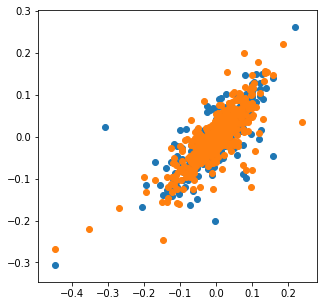

In [55]:
plt.figure(figsize=(5,5))
plt.scatter(CRIX_future_Open.loc[:,'log return CRIX'], CRIX_future_Open.loc[:,'log return future'])
plt.scatter(CRIX_future_Close.loc[:,'log return CRIX'], CRIX_future_Close.loc[:,'log return future'])

In [56]:
print(CRIX_future_Open.head().to_latex())

\begin{tabular}{llrrrr}
\toprule
{} &                      Date &           CRIX &   future &  log return CRIX &  log return future \\
\midrule
0 & 2021-02-04 00:00:00+00:00 &  104518.468839 &  38080.0 &         0.054757 &           0.046220 \\
1 & 2021-02-03 00:00:00+00:00 &   98949.179255 &  36360.0 &         0.059741 &           0.061097 \\
2 & 2021-02-02 00:00:00+00:00 &   93210.948461 &  34205.0 &         0.002204 &           0.014429 \\
3 & 2021-02-01 00:00:00+00:00 &   93005.711051 &  33715.0 &         0.013628 &          -0.008271 \\
4 & 2021-01-29 00:00:00+00:00 &   91746.863103 &  33995.0 &         0.081917 &           0.092065 \\
\bottomrule
\end{tabular}



In [57]:
print(CRIX_future_Close.head().to_latex())

\begin{tabular}{llrrrr}
\toprule
{} &                      Date &           CRIX &   future &  log return CRIX &  log return future \\
\midrule
0 & 2021-02-05 00:00:00+00:00 &  103348.488555 &  38220.0 &        -0.011257 &           0.011314 \\
1 & 2021-02-04 00:00:00+00:00 &  104518.468839 &  37790.0 &         0.054757 &           0.033774 \\
2 & 2021-02-03 00:00:00+00:00 &   98949.179255 &  36535.0 &         0.059741 &           0.064146 \\
3 & 2021-02-02 00:00:00+00:00 &   93210.948461 &  34265.0 &        -0.016175 &          -0.026353 \\
4 & 2021-01-30 00:00:00+00:00 &   94730.919657 &  35180.0 &         0.032007 &           0.061398 \\
\bottomrule
\end{tabular}



In [58]:
C = Gaussian({'rho':0.8}, stats.uniform, stats.uniform)
C = t_Copula({'rho':0.8, 'nu':2}, stats.uniform, stats.uniform, 2)

In [59]:
rs_Open = CRIX_future_Open.loc[:,'log return CRIX']
rs_Open.dropna(inplace=True)

rf_Open = CRIX_future_Open.loc[:,'log return future']
rf_Open.dropna(inplace=True)

u_Open = ECDF(rs_Open)(rs_Open)
v_Open = ECDF(rf_Open)(rf_Open)

C.canonical_calibrate(u_Open,v_Open)

Optimization terminated successfully.
         Current function value: -0.750559
         Iterations: 127
         Function evaluations: 240


array([0.87480695, 2.        ])

In [60]:
rs_Close = CRIX_future_Close.loc[:,'log return CRIX']
rs_Close.dropna(inplace=True)

rf_Close = CRIX_future_Close.loc[:,'log return future']
rf_Close.dropna(inplace=True)

u_Close = ECDF(rs_Close)(rs_Close)
v_Close = ECDF(rf_Close)(rf_Close)
C = t_Copula({'rho':0.8, 'nu':2}, stats.uniform, stats.uniform, 2)
C.canonical_calibrate(u_Close,v_Close)

Optimization terminated successfully.
         Current function value: -0.618130
         Iterations: 117
         Function evaluations: 227


array([0.81684398, 2.        ])

In [61]:
rs_mean = (CRIX_future_Open.loc[:,'log return CRIX'] + CRIX_future_Close.loc[:,'log return CRIX'])/2
rf_mean = (CRIX_future_Open.loc[:,'log return future'] + CRIX_future_Close.loc[:,'log return future'])/2

u_mean = ECDF(rs_mean)(rs_mean)
v_mean = ECDF(rf_mean)(rf_mean)

C.canonical_calibrate(u_mean,v_mean)

Optimization terminated successfully.
         Current function value: -0.872823
         Iterations: 83
         Function evaluations: 172


array([0.90516305, 2.84819037])

Text(0, 0.5, 'CRIX return quantile level')

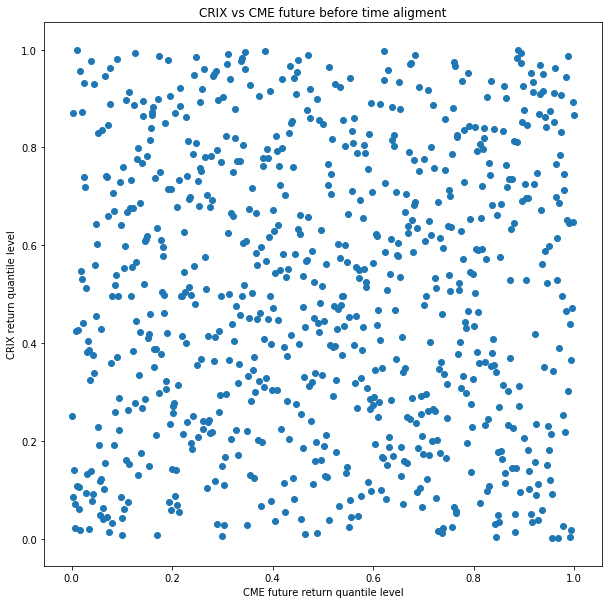

In [69]:
plt.figure(figsize=(10,10))
plt.title("CRIX vs CME future before time aligment")
plt.scatter(u_Close[:-1],v_Close[1:], label='CRIX future Close')
plt.xlabel('CME future return quantile level')
plt.ylabel('CRIX return quantile level')

Text(0, 0.5, 'CRIX return quantile level')

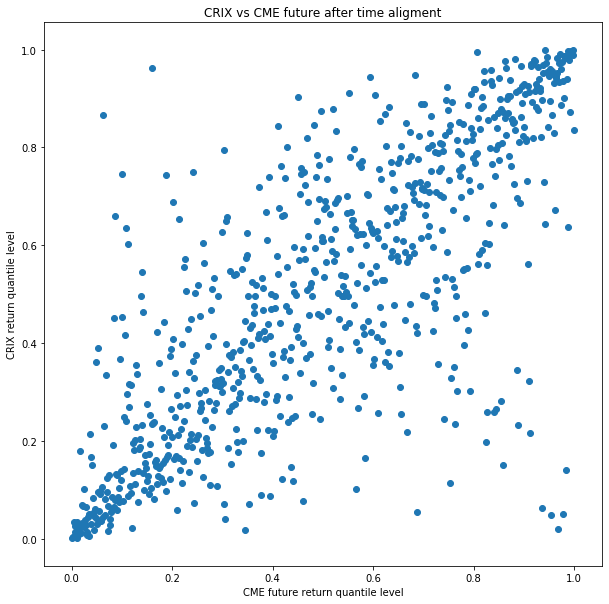

In [70]:
plt.figure(figsize=(10,10))
plt.title("CRIX vs CME future after time aligment")
plt.scatter(u_Close, v_Close, label='CRIX future Close')
plt.xlabel('CME future return quantile level')
plt.ylabel('CRIX return quantile level')

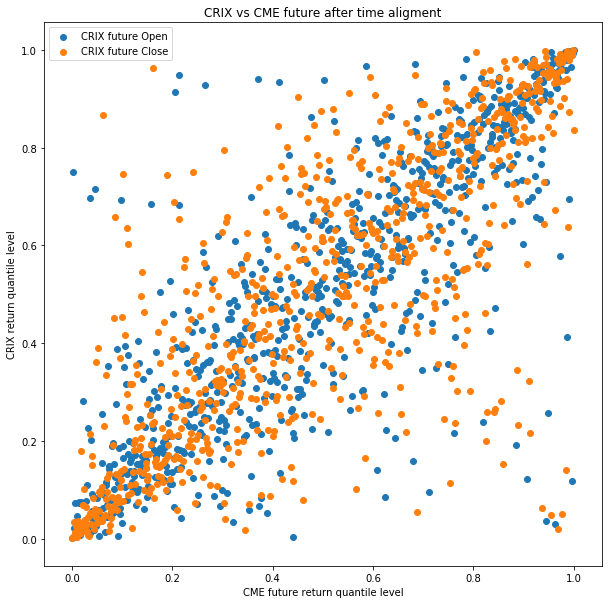

In [72]:
plt.figure(figsize=(10,10))
plt.title("CRIX vs CME future after time aligment")
plt.scatter(u_Open,v_Open, label='CRIX future Open')
plt.scatter(u_Close,v_Close, label='CRIX future Close')
# plt.scatter(u_mean,v_mean, label='CRIX mean future mean')
plt.xlabel('CME future return quantile level')
plt.ylabel('CRIX return quantile level')
plt.legend()
plt.savefig('../latex/_pics_notes/CRIX_future_Open_Close.pdf')

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

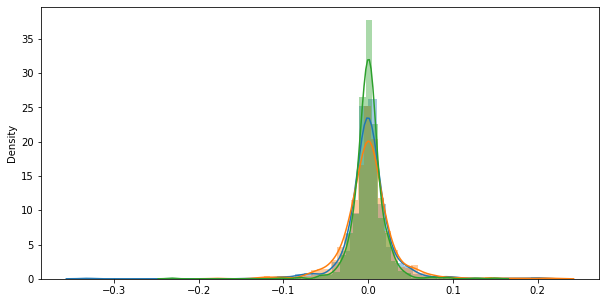

In [36]:
h=1
plt.figure(figsize=(10,5))

sns.distplot(rs_Open-h*rf_Open)

sns.distplot(rs_Close-h*rf_Close)

sns.distplot(rs_mean-h*rf_mean)


In [37]:
variables = [rs_Open, rf_Open, rs_Close, rf_Close]#, rs_mean, rf_mean]
variables_name = ["rs_Open" , "rf_Open",
                  "rs_Close", "rf_Close"]#,
                 # "rs_mean" , "rf_mean"]


tau_matrix = np.ones((len(variables), len(variables)))

for i, r1 in enumerate(variables):
    for j, r2 in enumerate(variables):
        tau_matrix[i,j] = stats.kendalltau(r1, r2)[0]

In [38]:
tau_matrix = pd.DataFrame(tau_matrix)

tau_matrix.index = variables_name
tau_matrix.columns = variables_name
print(tau_matrix.to_latex())


\begin{tabular}{lrrrr}
\toprule
{} &   rs\_Open &   rf\_Open &  rs\_Close &  rf\_Close \\
\midrule
rs\_Open  &  1.000000 &  0.673266 &  0.087482 &  0.168210 \\
rf\_Open  &  0.673266 &  1.000000 &  0.061379 &  0.103468 \\
rs\_Close &  0.087482 &  0.061379 &  1.000000 &  0.608429 \\
rf\_Close &  0.168210 &  0.103468 &  0.608429 &  1.000000 \\
\bottomrule
\end{tabular}



In [32]:
import os

def create_processed_data(data_name, data, train_size, test_size, step_size ):
    if os.path.exists("../processed_data/%s/" %data_name )==False:
        os.mkdir("../processed_data/%s/" %data_name)
        os.mkdir("../processed_data/%s/train/" %data_name)
        os.mkdir("../processed_data/%s/test/" %data_name)
        
    n = int(np.floor((len(data) - train_size - test_size)/step_size))
    train_set = []
    test_set = []

    for i in range(n):
        _data = data.iloc[(i*step_size):((i)*step_size)+train_size+test_size]
        test = _data.iloc[:test_size,]
        train = _data.iloc[test_size:,]
        train_set.append(train)
        test_set.append(test)

    for i in range(len(train_set)):
        train_set[i].to_csv("../processed_data/%s/train/" %data_name +str(i)+".csv")
        test_set[i].to_csv("../processed_data/%s/test/" %data_name +str(i)+".csv")

In [33]:
train_size_arr = [300,500,300,500,300]
test_size_arr  = [30, 30, 5,  5  ,100]
step_size_arr  = [30, 30, 5,  5  ,5]

root = 'CRIX_future_Open_v'
data_name_arr = [root+str(i) for i in range(1, len(train_size_arr)+1)]


for i in range(len(train_size_arr)):
    create_processed_data(data_name_arr[i],CRIX_future_Open,
                          train_size_arr[i],
                          test_size_arr[i],
                          step_size_arr[i])

In [34]:
# Sanity Check
pd.read_csv('../processed_data/CRIX_future_Open_v4/test/10.csv').tail()

,Unnamed: 0,Date,CRIX,future,log return CRIX,log return future
0,50,2020-11-20 00:00:00+00:00,50037.407143,18050.0,0.001657,0.001941
1,51,2020-11-19 00:00:00+00:00,49954.561140,18015.0,0.007707,0.007522
2,52,2020-11-18 00:00:00+00:00,49571.024637,17880.0,0.053542,0.052530
3,53,2020-11-17 00:00:00+00:00,46986.702488,16965.0,0.045949,0.050162
4,54,2020-11-16 00:00:00+00:00,44876.558227,16135.0,-0.013694,-0.022066


In [35]:
pd.read_csv('../processed_data/CRIX_future_Open_v4/train/10.csv').head()

,Unnamed: 0,Date,CRIX,future,log return CRIX,log return future
0,55,2020-11-13 00:00:00+00:00,45495.327218,16495.0,0.032531,0.024859
1,56,2020-11-12 00:00:00+00:00,44039.144060,16090.0,0.025936,0.037035
2,57,2020-11-11 00:00:00+00:00,42911.616105,15505.0,-0.003459,-0.001611
3,58,2020-11-10 00:00:00+00:00,43060.287978,15530.0,-0.010816,-0.017869
4,59,2020-11-09 00:00:00+00:00,43528.571574,15810.0,0.000183,0.000949


In [36]:
future_raw.dropna(inplace=True)
print(future_raw.head().iloc[:,1:5].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     Open &     High &      Low &    Close \\
\midrule
2021-02-02 23:00:00+00:00 &  36360.0 &  38155.0 &  36240.0 &  37790.0 \\
2021-02-01 23:00:00+00:00 &  34205.0 &  36665.0 &  34070.0 &  36535.0 \\
2021-01-31 23:00:00+00:00 &  33715.0 &  35280.0 &  32800.0 &  34265.0 \\
2021-01-28 23:00:00+00:00 &  33995.0 &  39530.0 &  32590.0 &  35180.0 \\
2021-01-27 23:00:00+00:00 &  31005.0 &  33710.0 &  30350.0 &  33085.0 \\
\bottomrule
\end{tabular}



In [37]:
Open = np.array(future_raw.Open)[:-1]

In [46]:
Close = np.array(future_raw.Close)[1:]

In [47]:
diff = (Open - Close)/Close

In [48]:
np.mean(diff)

0.0023642392413332053

In [49]:
np.std(diff)

0.022068912765736356

In [50]:
np.median(diff)

0.0013245033112582781

In [51]:
np.min(diff)

-0.12190287413280476

In [52]:
np.max(diff)

0.16394361339828425

In [53]:
np.quantile(diff, 0.75)

0.008146639511201629

In [54]:
np.quantile(diff, 0.25)

-0.0041279669762641896

In [31]:
future

NameError: name 'future' is not defined